# __Raízes: Exemplos__

In [19]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from CB2325NumericaG6.raizes import bisseccao, secante, newton_raphson, plot_secante, plot_bisseccao, plot_newton_raphson, plt

from numpy import cos, sin, e, pi, log

---

## Exemplo 1:

$$ f(x) = 3x+1 $$
$$ x \in [-2,2] \Rightarrow x = -\frac{1}{3} \approx -0.333333... $$

|              Método               |          Resultado           |             Erro             |
|             Bisseção              |     -0.33333301544189453     |      0.6666663487752278      |
---------------------------------------------------------------------------------------------------
|              Secante              |     -0.3333333333333333      |      0.6666666666666666      |
---------------------------------------------------------------------------------------------------
|          Newton Raphson           |     -0.3333333333333335      |      0.6666666666666667      |
---------------------------------------------------------------------------------------------------


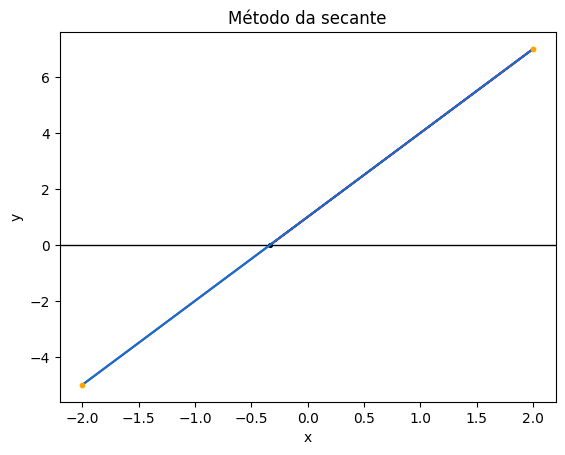

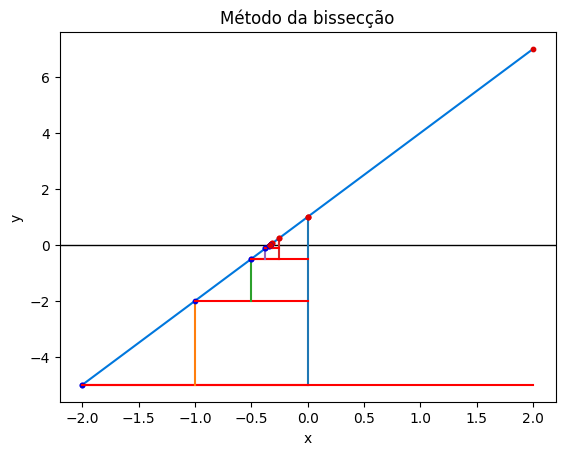

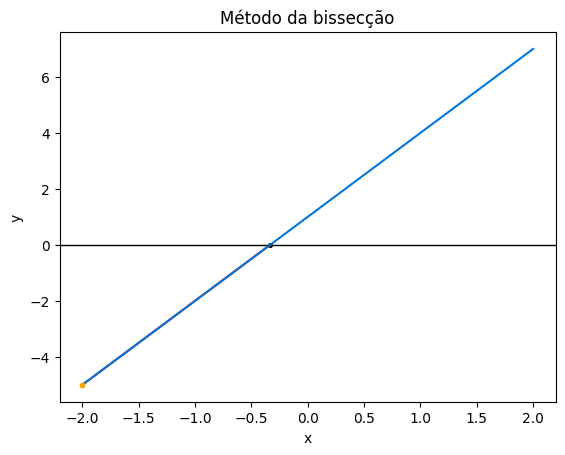

In [30]:
f = lambda x: 3*x + 1
df = lambda x: 3
raiz = 1/3
a,b = -2,2

resultado_bissecao = bisseccao(f, a, b, 1e-6)
resultado_secante = secante(f, a, b, 1e-6)
resultado_newton = newton_raphson(f, df, b, 1e-6)

print(f'|{"Método":^35}|{"Resultado":^30}|{"Erro":^30}|')
print('='*99)

print(f'|{"Bisseção":^35}|{resultado_bissecao:^30}|{abs(raiz-resultado_bissecao):^30}|')
print('-'*99)

print(f'|{"Secante":^35}|{resultado_secante:^30}|{abs(raiz-resultado_secante):^30}|')
print('-'*99)

print(f'|{"Newton Raphson":^35}|{resultado_newton:^30}|{abs(raiz-resultado_newton):^30}|')
print('-'*99)

plot_secante(f,(a,b),a,b, 1e-6)
plot_bisseccao(f, (a,b),a,b)
plot_newton_raphson(f,(a,b),df,a)
plt.show()

---

## Exemplo 2:

$$ f(x) = x^2 - 16 $$
$$ x \in [3,5] \Rightarrow x = 4 $$

|              Método               |          Resultado           |             Erro             |
|             Bisseção              |             4.0              |             0.0              |
---------------------------------------------------------------------------------------------------
|              Secante              |      3.9999999999889426      |    1.1057377236056709e-11    |
---------------------------------------------------------------------------------------------------
|          Newton Raphson           |      4.000000000000004       |    4.440892098500626e-15     |
---------------------------------------------------------------------------------------------------


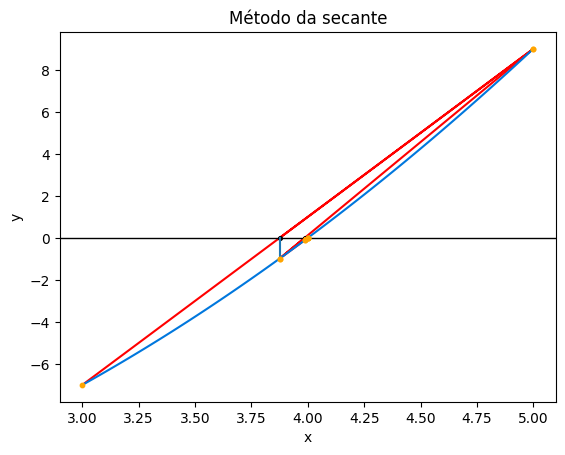

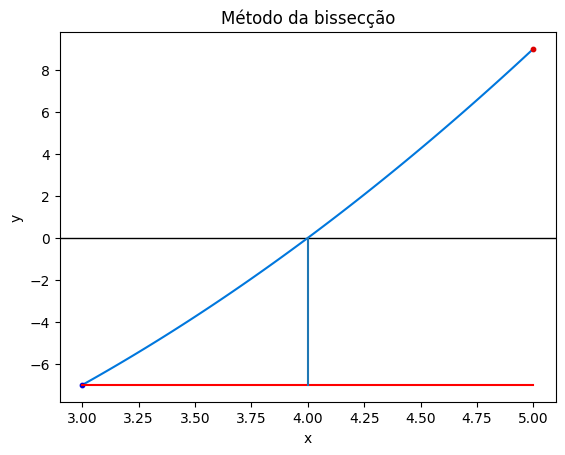

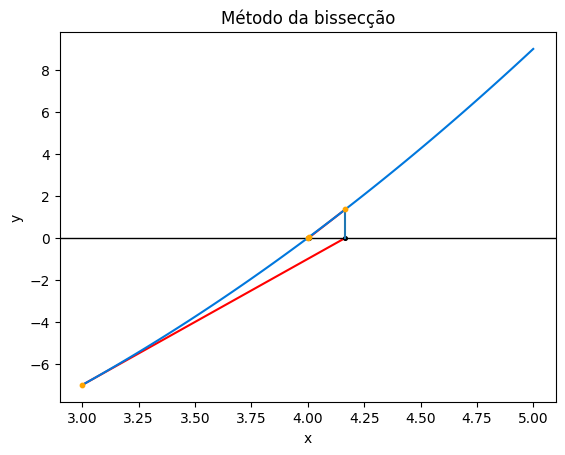

In [31]:
f = lambda x: x**2 - 16
df = lambda x: 2 * x
raiz = 4
a,b = 3,5

resultado_bissecao = bisseccao(f, a, b, 1e-6)
resultado_secante = secante(f, a, b, 1e-6)
resultado_newton = newton_raphson(f, df, b, 1e-6)

print(f'|{"Método":^35}|{"Resultado":^30}|{"Erro":^30}|')
print('='*99)

print(f'|{"Bisseção":^35}|{resultado_bissecao:^30}|{abs(raiz-resultado_bissecao):^30}|')
print('-'*99)

print(f'|{"Secante":^35}|{resultado_secante:^30}|{abs(raiz-resultado_secante):^30}|')
print('-'*99)

print(f'|{"Newton Raphson":^35}|{resultado_newton:^30}|{abs(raiz-resultado_newton):^30}|')
print('-'*99)

plot_secante(f,(a,b),a,b, 1e-6)
plot_bisseccao(f, (a,b),a,b)
plot_newton_raphson(f,(a,b),df,a)
plt.show()

---

## Exemplo 3:

$$ f(x) = x^2 - 5 $$

$$ x \in [2,3] \Rightarrow x = \sqrt{5} \approx 2.236067977... $$

|              Método               |          Resultado           |             Erro             |
|             Bisseção              |      2.236067771911621       |    2.0558816871130148e-07    |
---------------------------------------------------------------------------------------------------
|              Secante              |      2.236067926333413       |    5.116637691315873e-08     |
---------------------------------------------------------------------------------------------------
|          Newton Raphson           |      2.236067977499978       |    1.8829382497642655e-13    |
---------------------------------------------------------------------------------------------------


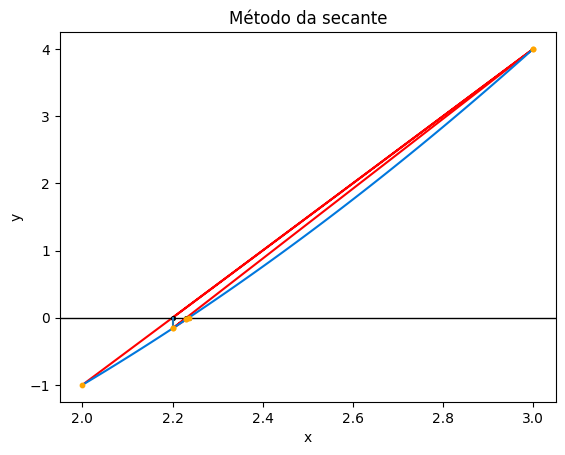

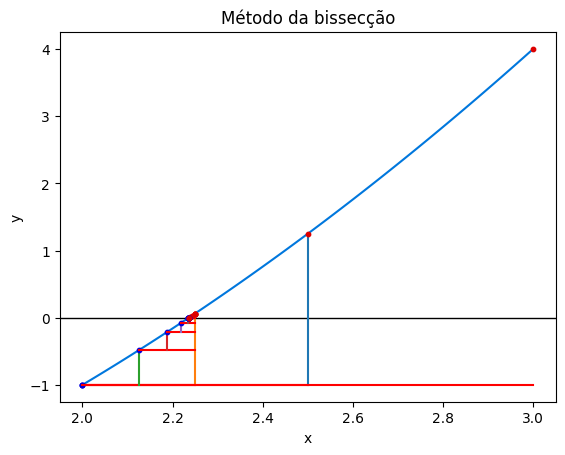

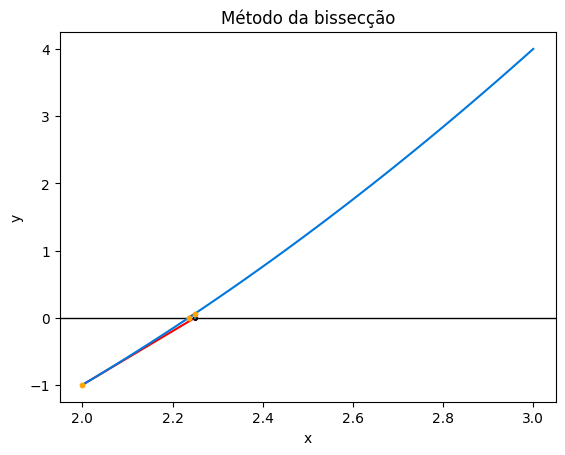

In [32]:
f = lambda x: x**2 - 5
df = lambda x: 2 * x
raiz = 5**0.5
a,b = 2,3

resultado_bissecao = bisseccao(f, a, b, 1e-6)
resultado_secante = secante(f, a, b, 1e-6)
resultado_newton = newton_raphson(f, df, b, 1e-6)

print(f'|{"Método":^35}|{"Resultado":^30}|{"Erro":^30}|')
print('='*99)

print(f'|{"Bisseção":^35}|{resultado_bissecao:^30}|{abs(raiz-resultado_bissecao):^30}|')
print('-'*99)

print(f'|{"Secante":^35}|{resultado_secante:^30}|{abs(raiz-resultado_secante):^30}|')
print('-'*99)

print(f'|{"Newton Raphson":^35}|{resultado_newton:^30}|{abs(raiz-resultado_newton):^30}|')
print('-'*99)

plot_secante(f,(a,b),a,b, 1e-6)
plot_bisseccao(f, (a,b),a,b)
plot_newton_raphson(f,(a,b),df,a)
plt.show()

---

## Exemplo 4

$$ f(x) = x^3 - 7 $$
$$ x \in [1,4] \Rightarrow x = \sqrt[3]{7} \approx 1.912931182... $$

|              Método               |          Resultado           |             Erro             |
|             Bisseção              |      1.9129311442375183      |    3.8534870627771056e-08    |
---------------------------------------------------------------------------------------------------
|              Secante              |      1.9129311827503097      |    2.2079227335325413e-11    |
---------------------------------------------------------------------------------------------------
|          Newton Raphson           |      1.9129311827723945      |    5.551115123125783e-15     |
---------------------------------------------------------------------------------------------------


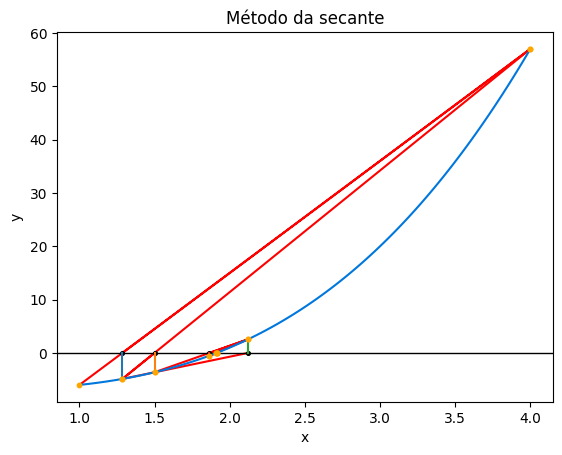

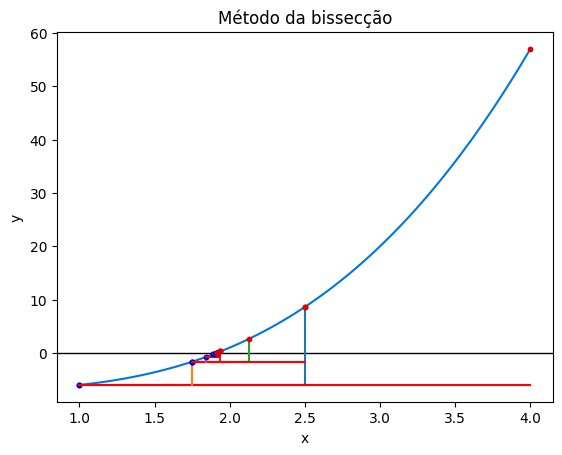

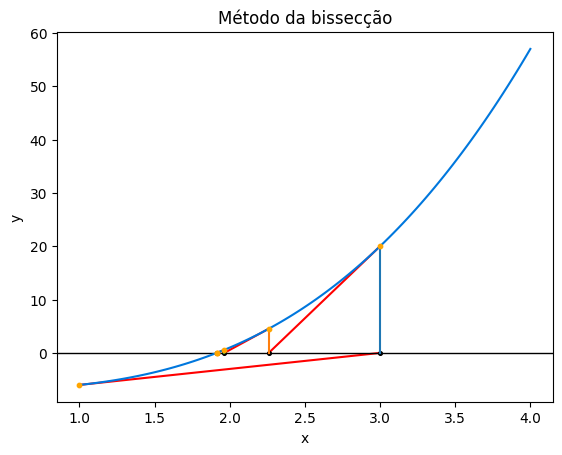

In [45]:
f = lambda x: x**3 - 7
df = lambda x: 3*x**2
raiz = 7**(1/3)
a,b = 1,4

resultado_bissecao = bisseccao(f, a, b, 1e-6)
resultado_secante = secante(f, a, b, 1e-6)
resultado_newton = newton_raphson(f, df, b, 1e-6)

print(f'|{"Método":^35}|{"Resultado":^30}|{"Erro":^30}|')
print('='*99)

print(f'|{"Bisseção":^35}|{resultado_bissecao:^30}|{abs(raiz-resultado_bissecao):^30}|')
print('-'*99)

print(f'|{"Secante":^35}|{resultado_secante:^30}|{abs(raiz-resultado_secante):^30}|')
print('-'*99)

print(f'|{"Newton Raphson":^35}|{resultado_newton:^30}|{abs(raiz-resultado_newton):^30}|')
print('-'*99)

plot_secante(f,(a,b),a,b, 1e-6)
plot_bisseccao(f, (a,b),a,b)
plot_newton_raphson(f,(a,b),df,a)
plt.show()

---

## Exemplo 5:

$$ f(x) = \cos(x) - \sin(x) $$
$$ x \in [0,1] \Rightarrow x = \frac{\pi}{4} \approx 0.785398163... $$

|              Método               |          Resultado           |             Erro             |
|             Bisseção              |      0.7853984832763672      |    3.198789189085005e-07     |
---------------------------------------------------------------------------------------------------
|              Secante              |      0.7853981577626146      |    5.634833710743692e-09     |
---------------------------------------------------------------------------------------------------
|          Newton Raphson           |      0.7853981759997019      |    1.2602253574023337e-08    |
---------------------------------------------------------------------------------------------------


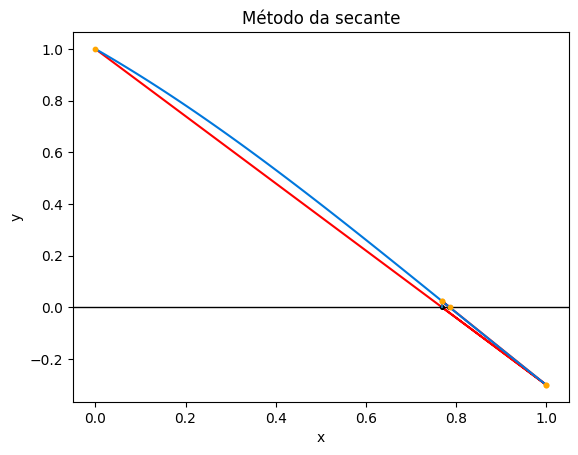

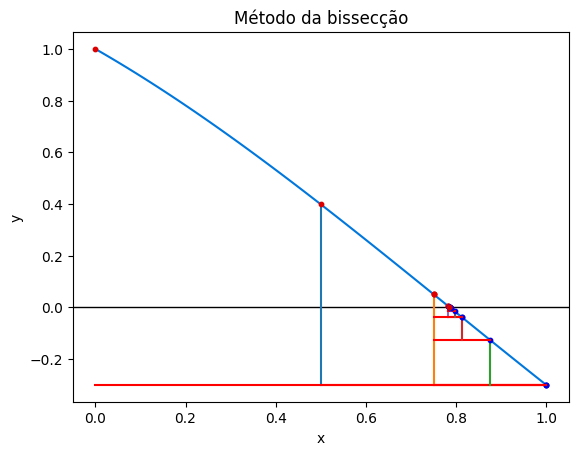

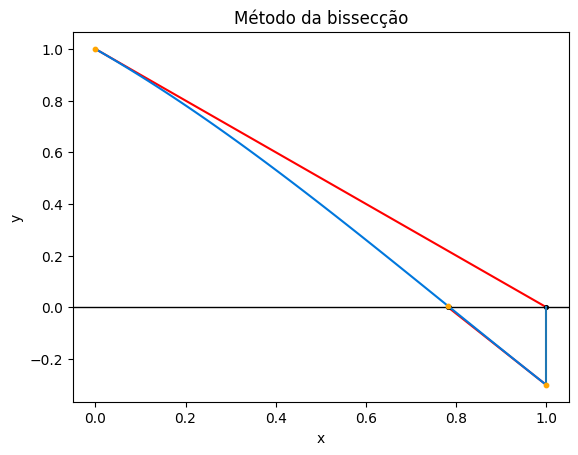

In [35]:
f = lambda x: cos(x) - sin(x)
df = lambda x: -sin(x) - cos(x)
raiz = pi/4
a,b = 0,1

resultado_bissecao = bisseccao(f, a, b, 1e-6)
resultado_secante = secante(f, a, b, 1e-6)
resultado_newton = newton_raphson(f, df, b, 1e-6)

print(f'|{"Método":^35}|{"Resultado":^30}|{"Erro":^30}|')
print('='*99)

print(f'|{"Bisseção":^35}|{resultado_bissecao:^30}|{abs(raiz-resultado_bissecao):^30}|')
print('-'*99)

print(f'|{"Secante":^35}|{resultado_secante:^30}|{abs(raiz-resultado_secante):^30}|')
print('-'*99)

print(f'|{"Newton Raphson":^35}|{resultado_newton:^30}|{abs(raiz-resultado_newton):^30}|')
print('-'*99)

plot_secante(f,(a,b),a,b, 1e-6)
plot_bisseccao(f, (a,b),a,b)
plot_newton_raphson(f,(a,b),df,a)
plt.show()

---

## Exemplo 6:

$$ f(x) = e^x-3 $$
$$ x \in [1,2] \Rightarrow x = \ln(3) \approx 1.098612288... $$

|              Método               |          Resultado           |             Erro             |
|             Bisseção              |      1.0986123085021973      |    1.9834087483516782e-08    |
---------------------------------------------------------------------------------------------------
|              Secante              |      1.098612288366849       |    3.0126079408887563e-10    |
---------------------------------------------------------------------------------------------------
|          Newton Raphson           |      1.0986122886681922      |    8.237854842718662e-14     |
---------------------------------------------------------------------------------------------------


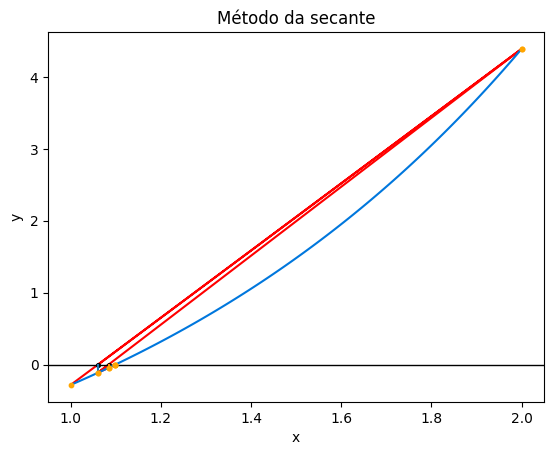

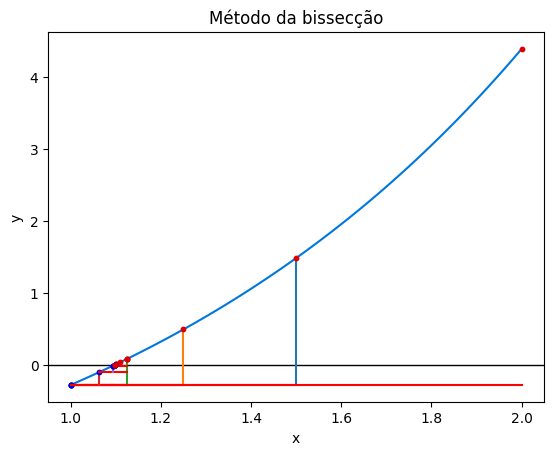

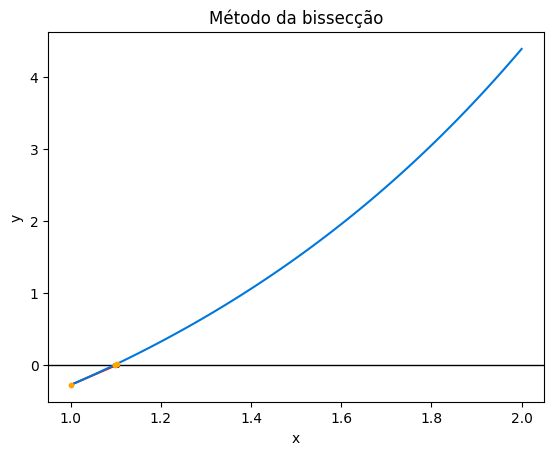

In [36]:
f = lambda x: e**x - 3
df = lambda x: e**x
raiz = log(3)
a,b = 1,2

resultado_bissecao = bisseccao(f, a, b, 1e-6)
resultado_secante = secante(f, a, b, 1e-6)
resultado_newton = newton_raphson(f, df, b, 1e-6)

print(f'|{"Método":^35}|{"Resultado":^30}|{"Erro":^30}|')
print('='*99)

print(f'|{"Bisseção":^35}|{resultado_bissecao:^30}|{abs(raiz-resultado_bissecao):^30}|')
print('-'*99)

print(f'|{"Secante":^35}|{resultado_secante:^30}|{abs(raiz-resultado_secante):^30}|')
print('-'*99)

print(f'|{"Newton Raphson":^35}|{resultado_newton:^30}|{abs(raiz-resultado_newton):^30}|')
print('-'*99)

plot_secante(f,(a,b),a,b, 1e-6)
plot_bisseccao(f, (a,b),a,b)
plot_newton_raphson(f,(a,b),df,a)
plt.show()

---